## Mesh and initial velocity for SST RANS simulation of the ABL

### Mesh

__Calculates mesh vertex, $v_i$, locations by [1-2]:__

$v_0 = 0.0$

$z_1 = \frac{z_1^+ \nu}{u_*} \gamma$ where $\nu=1.5 \times 10^{-5}$ and $u_*=.3880$ m/s

$\gamma$ is chosen s.t. $z_u - (z_i + \Delta z_i/2) < .1$ and $z_1 \approx 1$

$v_1 = 2 z_1$

$\Delta_1 = v_1 \times \text{expansion_ratio}$

$\Delta_{i+1} = \Delta_i \times \text{expansion_ratio}$

For [2], the expansion ratio is 1.17

$v_{i+1} = v_i + \Delta_{i+1}$ while $100 > v_i$

$v_{i+1} = v_i + \Delta$ for $v_i \in [100, 500]$

This is the same method used to calculate cell centers in [1] and [2], modified to calculate cell vertices instead.

__References:__

[1] 2011 M. C. Bautista, Turbulence modelling of the atmospheric boundary layer over complex topography, École de Technologie Supérieure

[2] 2015 M. C. Bautista, L. Dufresne, C. Masson, Hybrid turbulence models for atmospheric flow, E3S Web of Conferences

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [2]:
# convert cell centers to cell vertices
def get_cellVertices(z_max, expansion_ratio, z_u, delta, z_1_plus, u_star, nu, gamma):
    z_1 = z_1_plus*nu/u_star
    z_1 *= gamma
    v_1 = 2.*z_1
    vs = np.array([0., v_1])

    v_i = v_1
    delta_i = v_i*expansion_ratio
    v_i += delta_i

    while z_u > v_i:
        vs = np.append(vs, v_i)
        delta_i *= expansion_ratio
        v_i += delta_i

    vs = np.append(vs, np.arange(z_u+delta, z_max+delta, delta))

    return vs

In [3]:
z_max = 500. # domain height [2]
expansion_ratio = 1.17 # [2]
delta = 15. # [2]

# z_u ~= 100 [2]
# actual value calculated by 
#   np.ceil((z_max - z_u)/15.) (=27)
#   z_max - delta**27. (=95.0)
z_u = 95.  

z_1_plus = 1.0 # [2]
u_star = .3880 # friction velocity
nu = 1.5*10**-5 # kinematic viscosity, from [1] table 2.2

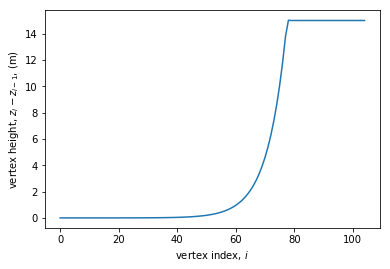

In [4]:
gamma = 1.003 # manually tune this so slope in plot increases monotonically before flatlining (z_iplus1 ~= z_u at transition)
vs = get_cellVertices(z_max, expansion_ratio, z_u, delta, z_1_plus, u_star, nu, gamma)

fig, ax = plt.subplots()
ax.plot([vs[i+1]-vs[i] for i in range(len(vs)-1)])
ax.set(xlabel = 'vertex index, $i$', ylabel = 'vertex height, $z_i - z_{i-1}$, (m)')
plt.show()

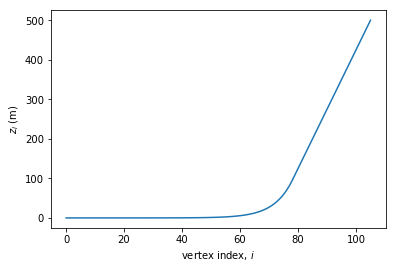

In [5]:
# check that vertex z location looks reasonable
fig, ax = plt.subplots()
ax.plot(vs)
ax.set(xlabel = 'vertex index, $i$', ylabel = '$z_i$ (m)')
plt.show()

In [6]:
# copy into nalu_abl_mesh:z_spacing:node_spacing_ratios
node_spacing_ratios = vs/z_max
print(list(node_spacing_ratios))

[0.0, 1.5510309278350516e-07, 3.365737113402062e-07, 5.488943350515463e-07, 7.973094647938143e-07, 1.0879551665922679e-06, 1.4280106376964585e-06, 1.8258755388883615e-06, 2.291377473282888e-06, 2.836014736524484e-06, 3.4732403345171518e-06, 4.2187942841685724e-06, 5.091092405260734e-06, 6.111681206938564e-06, 7.3057701049016255e-06, 8.702854115518406e-06, 1.033744240794004e-05, 1.224991071007335e-05, 1.4487498623569324e-05, 1.710547648235961e-05, 2.016851057714425e-05, 2.3752260468042275e-05, 2.7945247840392968e-05, 3.285104306604328e-05, 3.859082348005414e-05, 4.530636656444684e-05, 5.3163551973186314e-05, 6.23564589014115e-05, 7.311216000743496e-05, 8.56963303014824e-05, 0.0001004198095455179, 0.00011764628026103945, 0.00013780125099819966, 0.00016138256676067708, 0.00018897270620277568, 0.00022125316935003102, 0.0002590213112323198, 0.00030321003723459767, 0.00035491084665726275, 0.00041540079368178085, 0.00048617403170046704, 0.0005689787201823298, 0.0006658602057061094, 0.00077921

In [7]:
len(node_spacing_ratios) # nalu_abl_mesh:vertices:mesh_dimensions[3]= 105 (b/c 106 vertices means 105 mesh elements)

106

In [8]:
x_max = 3000.
y_max = 500.

# 201 elements in x-dir and 34 in y-dir
# b/c e.g. 15 goes into 3000 200 times; meaning 201 mesh elements fit
x_max/delta, y_max/delta

(200.0, 33.333333333333336)

### Initial velocity

__Calculates initial velocity by [1-2]:__

$u=\frac{u_*}{\kappa} ln \left( \frac{z+z_0}{z_0} \right)$

$\kappa = .4$

$z_0=.1$m

$u_*=.3880$ m/s

$u=u \left(1+\text{Unif}[-.2,.2] \right)$

In [9]:
kappa = .4 #von Karman constant; from 2011 Masson Table-A I-1 (k-omega SST constants for atmospheric flows)
z_0 = .1 #aerodynamic roughness [2]

In [10]:
def get_u(v):
    return u_star/kappa*np.log((v+z_0)/z_0)

In [11]:
us = [get_u(v) for v in vs]

In [12]:
# add +/- 20% random fluctuations (assuming uniform--not specified)
us_scaling = 1. + np.random.uniform(-.2,.2, len(us))
us_scaled = [max(u*u_scaling, 0.0) for (u, u_scaling) in zip(us, us_scaling)]

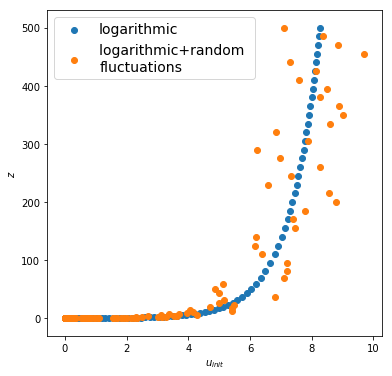

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(us, vs, label='logarithmic')
plt.scatter(us_scaled, vs, label='logarithmic+random \nfluctuations')
ax = plt.gca()
ax.set_xlabel(r'$u_{init}$')
ax.set_ylabel(r'$z$')
plt.rcParams["font.size"] = "14"
# plt.legend(fontsize='xx-small')
plt.legend()
plt.show()

In [14]:
# copy this into yaml mesh setup file in nalu_preprocess:velocity:heights
print(list(vs))

[0.0, 7.755154639175258e-05, 0.0001682868556701031, 0.0002744471675257732, 0.00039865473239690714, 0.0005439775832961339, 0.0007140053188482293, 0.0009129377694441807, 0.001145688736641444, 0.001418007368262242, 0.0017366201672585758, 0.002109397142084286, 0.002545546202630367, 0.003055840603469282, 0.0036528850524508126, 0.004351427057759203, 0.00516872120397002, 0.006124955355036675, 0.007243749311784662, 0.008552738241179806, 0.010084255288572125, 0.011876130234021138, 0.013972623920196483, 0.01642552153302164, 0.01929541174002707, 0.022653183282223422, 0.026581775986593156, 0.031178229450705745, 0.036556080003717475, 0.0428481651507412, 0.050209904772758954, 0.05882314013051972, 0.06890062549909982, 0.08069128338033854, 0.09448635310138784, 0.11062658467501552, 0.1295106556161599, 0.15160501861729883, 0.17745542332863137, 0.20770039684089042, 0.2430870158502335, 0.28448936009116493, 0.3329301028530547, 0.3896057718844657, 0.4559163046512166, 0.5334996279883151, 0.6242721162927204, 

In [15]:
# copy contents of values file to yaml mesh setup file in nalu_preprocess:velocity:values
dict_file = {'values' : [[float(u), 0.0, 0.0] for u in us_scaled]}